# Installs

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
#from datetime import datetime
import datetime
#from pyathena import connect
import random

In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [4]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

import boto3

OK


## Load Data

In [5]:
# Read from S3 - Enter filename for Key
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-w210-eth', Key='pipeline_df_20211117_2_non_winsorized.csv')
data = pd.read_csv(obj['Body'])
data.head()

,number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,NaN,NaN,2021-08-05 08:34:14-04:00,2021-08-05,8,0,34,0,3,1
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,NaN,NaN,2021-08-05 08:34:17-04:00,2021-08-05,8,0,34,0,3,1
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,NaN,NaN,2021-08-05 08:34:28-04:00,2021-08-05,8,0,34,0,3,1


In [6]:
data.rename(columns={'number': 'block_number'}, inplace=True)

In [7]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,NaN,NaN,2021-08-05 08:34:14-04:00,2021-08-05,8,0,34,0,3,1
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,NaN,NaN,2021-08-05 08:34:17-04:00,2021-08-05,8,0,34,0,3,1
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,NaN,NaN,2021-08-05 08:34:28-04:00,2021-08-05,8,0,34,0,3,1


In [8]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [9]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 12965000
median block number: 13246123.0
max block number: 13527858


In [10]:
pd.options.display.max_columns = None
data.describe()

,block_number,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
count,5.537010e+05,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553701.000000,5.537010e+05,553701.000000,553701.000000,553700.000000,553697.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553692.000000,553672.000000,553647.000000,553597.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,5.519420e+05,5.519270e+05,5.520060e+05,5.519130e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324632e+07,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000002,2.873739e-07,5.659364,0.000004,0.003667,78482.656935,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,1.897053,1.898676,1.931698,1.970818,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,0.092125,0.088190,0.103078,0.118182,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,8.548464e+10,1.025643e+11,191.923693,7.974510e+06,8.332651e+09,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.1128

In [11]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,datetime_local,date,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,259,1.000000e+09,2021-08-05 12:33:42,1.386817e-07,2.717199e-07,0.695396,0.998047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,252779.100386,23000000000,3.612204e+10,21000,115927.633205,23000000000,3.612204e+10,259,0.0,0.000000e+00,0.402547,0.036380,-0.190108,-0.094139,0.266887,-0.079218,-0.290970,-0.472032,0.575488,-0.313610,-0.141907,-0.071168,0.266887,-0.079218,-0.290970,-0.472032,0.269608,0.457143,0.165714,0.079365,NaN,NaN,NaN,NaN,2021-08-05 08:33:42-04:00,2021-08-05,8,0,33,0,3,1
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,257,1.124968e+09,2021-08-05 12:33:55,1.386816e-07,2.717198e-07,0.157819,-0.000977,0.124968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,180995.634241,22500000000,3.423175e+10,21000,116673.712062,22500000000,3.423175e+10,257,0.0,1.182101e+08,0.189072,-0.123872,-0.042244,-0.415326,0.010515,0.204574,-0.011364,-0.246282,0.103627,0.105140,0.064655,-0.344422,0.010515,0.204574,-0.011364,-0.246282,0.809859,-0.095541,-0.059603,0.526882,inf,NaN,NaN,NaN,2021-08-05 08:33:55-04:00,2021-08-05,8,0,33,0,3,1
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,321,1.265451e+09,2021-08-05 12:34:14,-4.881426e-04,2.715871e-07,-0.390684,-0.000977,0.124878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,156396.102804,22000000

## Create train / dev / test splits

In [11]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [12]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg

In [13]:
data[['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5
count,5.519130e+05,5.520060e+05,5.519270e+05,5.519420e+05
mean,inf,inf,inf,inf
std,NaN,NaN,NaN,NaN
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
1%,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
5%,-9.442090e-01,-9.403094e-01,-9.369430e-01,-9.328319e-01
25%,-5.490742e-01,-5.424290e-01,-5.380213e-01,-5.322023e-01
50%,-2.146628e-03,-5.028516e-03,-3.360508e-03,-5.453605e-03
75%,1.209009e+00,1.176557e+00,1.152484e+00,1.126135e+00
90%,4.720016e+00,4.566230e+00,4.395243e+00,4.250104e+00


In [14]:
# truncate these fields to 95th percentile
mask5 = (data['max_priority_fee_per_gas_mean_pct_chg_last_5'] >= 10.24462)
data.loc[mask5, 'max_priority_fee_per_gas_mean_pct_chg_last_5'] = 10.24462
mask25 = (data['max_priority_fee_per_gas_mean_pct_chg_last_25_to_5'] >= 15.80224)
data.loc[mask25, 'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5'] = 15.80224
mask50 = (data['max_priority_fee_per_gas_mean_pct_chg_last_50_to_5'] >= 17.10101)
data.loc[mask50, 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5'] = 17.10101
mask100 = (data['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] >= 17.97416)
data.loc[mask100, 'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] = 17.97416

In [15]:
data[['base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5
count,553676.000000,553696.000000,553701.000000,553701.000000,551913.000000,552006.000000,551927.000000,551942.000000
mean,0.031613,0.012125,1.711082,1.726361,1.528488,1.454292,1.357921,1.036926
std,0.338931,0.161417,8.258244,8.345750,4.372858,4.170216,3.878216,2.803232
min,-0.875538,-0.501010,-0.998674,-0.998529,-1.000000,-1.000000,-1.000000,-1.000000
1%,-0.400268,-0.271274,-0.964824,-0.965054,-1.000000,-1.000000,-1.000000,-1.000000
5%,-0.288052,-0.206962,-0.897727,-0.898148,-0.944209,-0.940309,-0.936943,-0.932832
25%,-0.131409,-0.100492,-0.569231,-0.572193,-0.549074,-0.542429,-0.538021,-0.532202
50%,-0.007819,-0.010770,0.000000,0.000000,-0.002147,-0.005029,-0.003361,-0.005454
75%,0.138022,0.099301,1.315789,1.326087,1.209009,1.176557,1.152484,1.126135
90%,0.304036,0.223371,4.604651,4.641509,4.720016,4.566230,4.395243,4.250104


In [16]:
tip_cols = [col for col in data.columns if 'max_priority_fee_per_gas_mean_pct_chg' in col]
for c in tip_cols:
    data[c+'_log'] = np.log(data[c]+1.001)

In [17]:
data[['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_5_log']].describe(percentiles=[.01, .05, .25, 0.50, .75, .9, .95, .99])

,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_5_log
count,551913.000000,552006.000000,551927.000000,551942.000000
mean,-0.151794,-0.154600,-0.156755,-0.177242
std,1.829087,1.814265,1.795352,1.750740
min,-6.907755,-6.907755,-6.907755,-6.907755
1%,-6.907755,-6.907755,-6.907755,-6.907755
5%,-2.868377,-2.801966,-2.747982,-2.685779
25%,-0.794237,-0.779640,-0.770074,-0.757584
50%,-0.001147,-0.004037,-0.002363,-0.004464
75%,0.792997,0.778203,0.767087,0.754776
90%,1.744146,1.716898,1.685703,1.658438


### Set X & Y columns

In [18]:
# 'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
#       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',

X_columns = ['lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 
       #'smoothed_size_5_pct_chg_last_5',
       #'smoothed_size_5_pct_chg_last_25_to_5', 'smoothed_size_5_pct_chg_last_50_to_5',
       #'smoothed_size_5_pct_chg_last_100_to_5',
       'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block', 'gas_mean_pct_chg_last_5',
       'gas_mean_pct_chg_last_25_to_5', 'gas_mean_pct_chg_last_50_to_5',
       'gas_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
       'gas_price_mean_pct_chg_last_25_to_5',
       'gas_price_mean_pct_chg_last_50_to_5',
       'gas_price_mean_pct_chg_last_100_to_5', 'gas_used_mean_pct_chg_last_5',
       'gas_used_mean_pct_chg_last_25_to_5',
       'gas_used_mean_pct_chg_last_50_to_5',
       'gas_used_mean_pct_chg_last_100_to_5',
       'effective_gas_price_mean_pct_chg_last_5',
       'effective_gas_price_mean_pct_chg_last_25_to_5',
       'effective_gas_price_mean_pct_chg_last_50_to_5',
       'effective_gas_price_mean_pct_chg_last_100_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5',
       'max_priority_fee_per_gas_mean_pct_chg_last_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log',
       'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log',
       'number_transactions_in_block_pct_chg_last_5',
       'number_transactions_in_block_pct_chg_last_25_to_5',
       'number_transactions_in_block_pct_chg_last_50_to_5',
       'number_transactions_in_block_pct_chg_last_100_to_5',
        'hour_dummy', 'minute_dummy', 'weekday_dummy']

Y_column = ['effective_gas_price_mean']


In [19]:
data[X_columns].describe()

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5_log,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,hour_dummy,minute_dummy,weekday_dummy
count,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,551942.000000,551927.000000,552006.000000,551913.000000,551942.000000,551927.000000,552006.000000,551913.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,191.923693,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.112852,0.103634,0.116047,0.122426,0.126450,0.029485,0.056133,0.084671,0.112852,1.036926,1.357921,1.454292,1.528488,-0.177242,-0.156755,-0.154600,-0.151794,1.726361,1.711082,1.726032,1.740013,0.669406,0.100462,0.567629
std,1.625688e+05,7.744856e+14,1.450218e+21,5.735261e+04,1.167284e+05,1.021422e+07,2.181715e+06,142.233560,7.562234e+10,0.001569,0.003110,0.004630,0.006688,1.073559e-07,3.147282e-07,6.487696e-07,0.000001,1.267973e-03,0.001531,0.001617,0.001706,0.161417,0.338931,0.764655,0.914771,7.069762e+04,1.969949e+05,9.392680e+10,2.334474e+11,6.647432e+04,9.327788e+04,142.233560,1.196374,1.256028,1.240240,1.254392,3.468464,3.939107,3.396785,3.421949,1.066960,1.156502,1.202561,1.223231,3.468464,3.939107,3.396785,3.421949

### Check validity of data

In [20]:
#data[data.number_transactions_in_block_pct_chg_last_5.isna()]
data.number_transactions_in_block_pct_chg_last_5.isna().sum()

0

In [21]:
print("Percent NA's")
data[X_columns].isna().sum()/data[X_columns].count()

Percent NA's


lag_cutoff_60                                         0.000000
latest_avail_60                                       0.000009
datetime                                              0.000000
difficulty                                            0.000000
total_difficulty                                      0.000000
                                                        ...   
number_transactions_in_block_pct_chg_last_50_to_5     0.000000
number_transactions_in_block_pct_chg_last_100_to_5    0.000000
hour_dummy                                            0.000000
minute_dummy                                          0.000000
weekday_dummy                                         0.000000
Length: 66, dtype: float64

In [22]:
na_df = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df.sort_values(by='na', ascending=False)

,na
max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log,0.003240
max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,0.003240
max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log,0.003214
max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,0.003214
max_priority_fee_per_gas_mean_pct_chg_last_5_log,0.003187
...,...
gas_mean_pct_chg_last_25_to_5,0.000000
gas_mean_pct_chg_last_50_to_5,0.000000
gas_mean_pct_chg_last_100_to_5,0.000000
gas_price_mean_pct_chg_last_5,0.000000


In [23]:
data[X_columns].dropna().shape

(547663, 66)

In [24]:
data_original = data.copy()
data = data[X_columns+Y_column+['block_number']].dropna()

In [25]:
data.shape

(547663, 68)

In [26]:
na_df2 = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df2.sort_values(by='na', ascending=False)

,na
lag_cutoff_60,0.0
effective_gas_price_mean_pct_chg_last_50_to_5,0.0
gas_mean_pct_chg_last_5,0.0
gas_mean_pct_chg_last_25_to_5,0.0
gas_mean_pct_chg_last_50_to_5,0.0
...,...
base_fee_per_gas_pct_chg_last_100_to_5,0.0
gas_min,0.0
gas_mean,0.0
gas_price_min,0.0


### Create the data sets

In [27]:
data['datetime'] = pd.to_datetime(data['datetime'])
# val_date = pd.to_datetime(datetime.date(2021, 10, 1))
# test_date = pd.to_datetime(datetime.date(2021, 10, 15))
val_date = pd.to_datetime(datetime.date(2021, 10, 5))
test_date = pd.to_datetime(datetime.date(2021, 10, 19))

X_train = data[data['datetime']<val_date][X_columns]
Y_train = data[data['datetime']<val_date][Y_column]

X_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][X_columns]
Y_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][Y_column]

X_test = data[data['datetime']>test_date][X_columns]
Y_test = data[data['datetime']>test_date][Y_column]

# X_train = data[data.block_number<12967800][X_columns]
# Y_train = data[data.block_number<12967800][Y_column]

# X_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][X_columns]
# Y_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][Y_column]

# X_test = data[data.block_number>13141000][X_columns]
# Y_test = data[data.block_number>13141000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

In [28]:
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_dev shape:", Y_dev.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (378271, 66)
X_dev shape: (87631, 66)
X_test shape: (81761, 66)
Y_train shape: (378271, 1)
Y_dev shape: (87631, 1)
Y_test shape: (81761, 1)


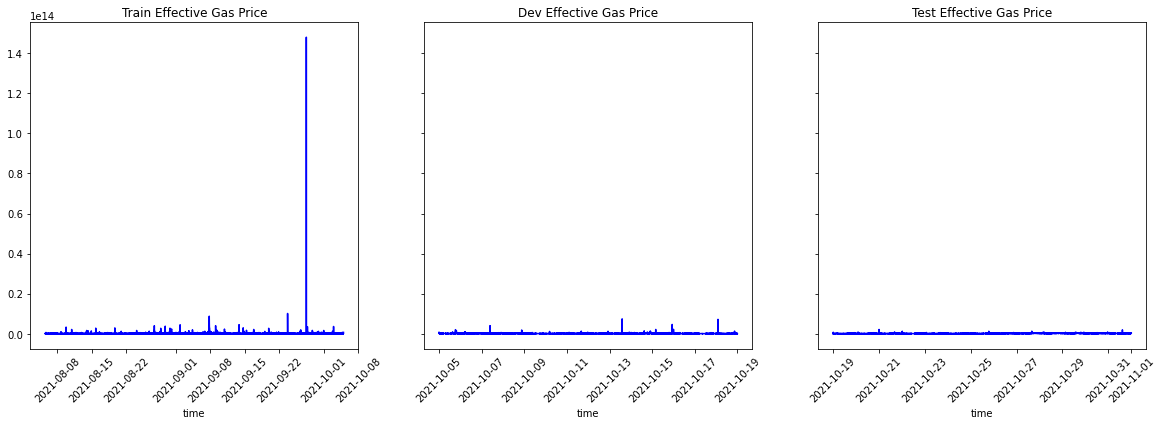

In [30]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
plt.show()

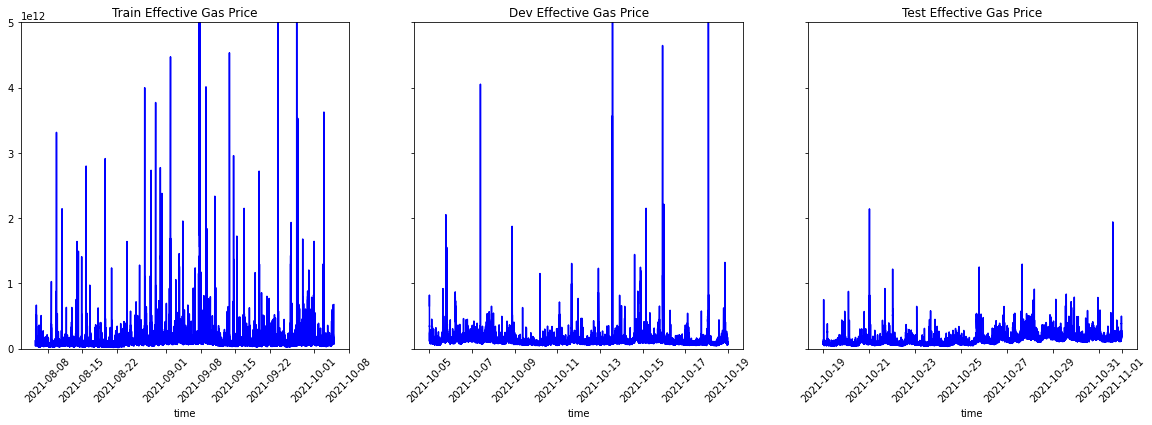

In [31]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
ax1[0].set_ylim(0, 5000000000000)
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
ax1[1].set_ylim(0, 5000000000000)
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
ax1[2].set_ylim(0, 5000000000000)
plt.show()

In [32]:
Y_train.describe(percentiles=[.01, .05, .10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,effective_gas_price_mean
count,3.782710e+05
mean,9.284552e+10
std,2.715820e+11
min,1.596813e+10
1%,2.840550e+10
5%,3.656959e+10
10%,4.188432e+10
25%,5.305154e+10
50%,7.268458e+10
75%,1.014788e+11


## Linear Regression

#### Create a heatmap to limit multicollinearity when testing regressions

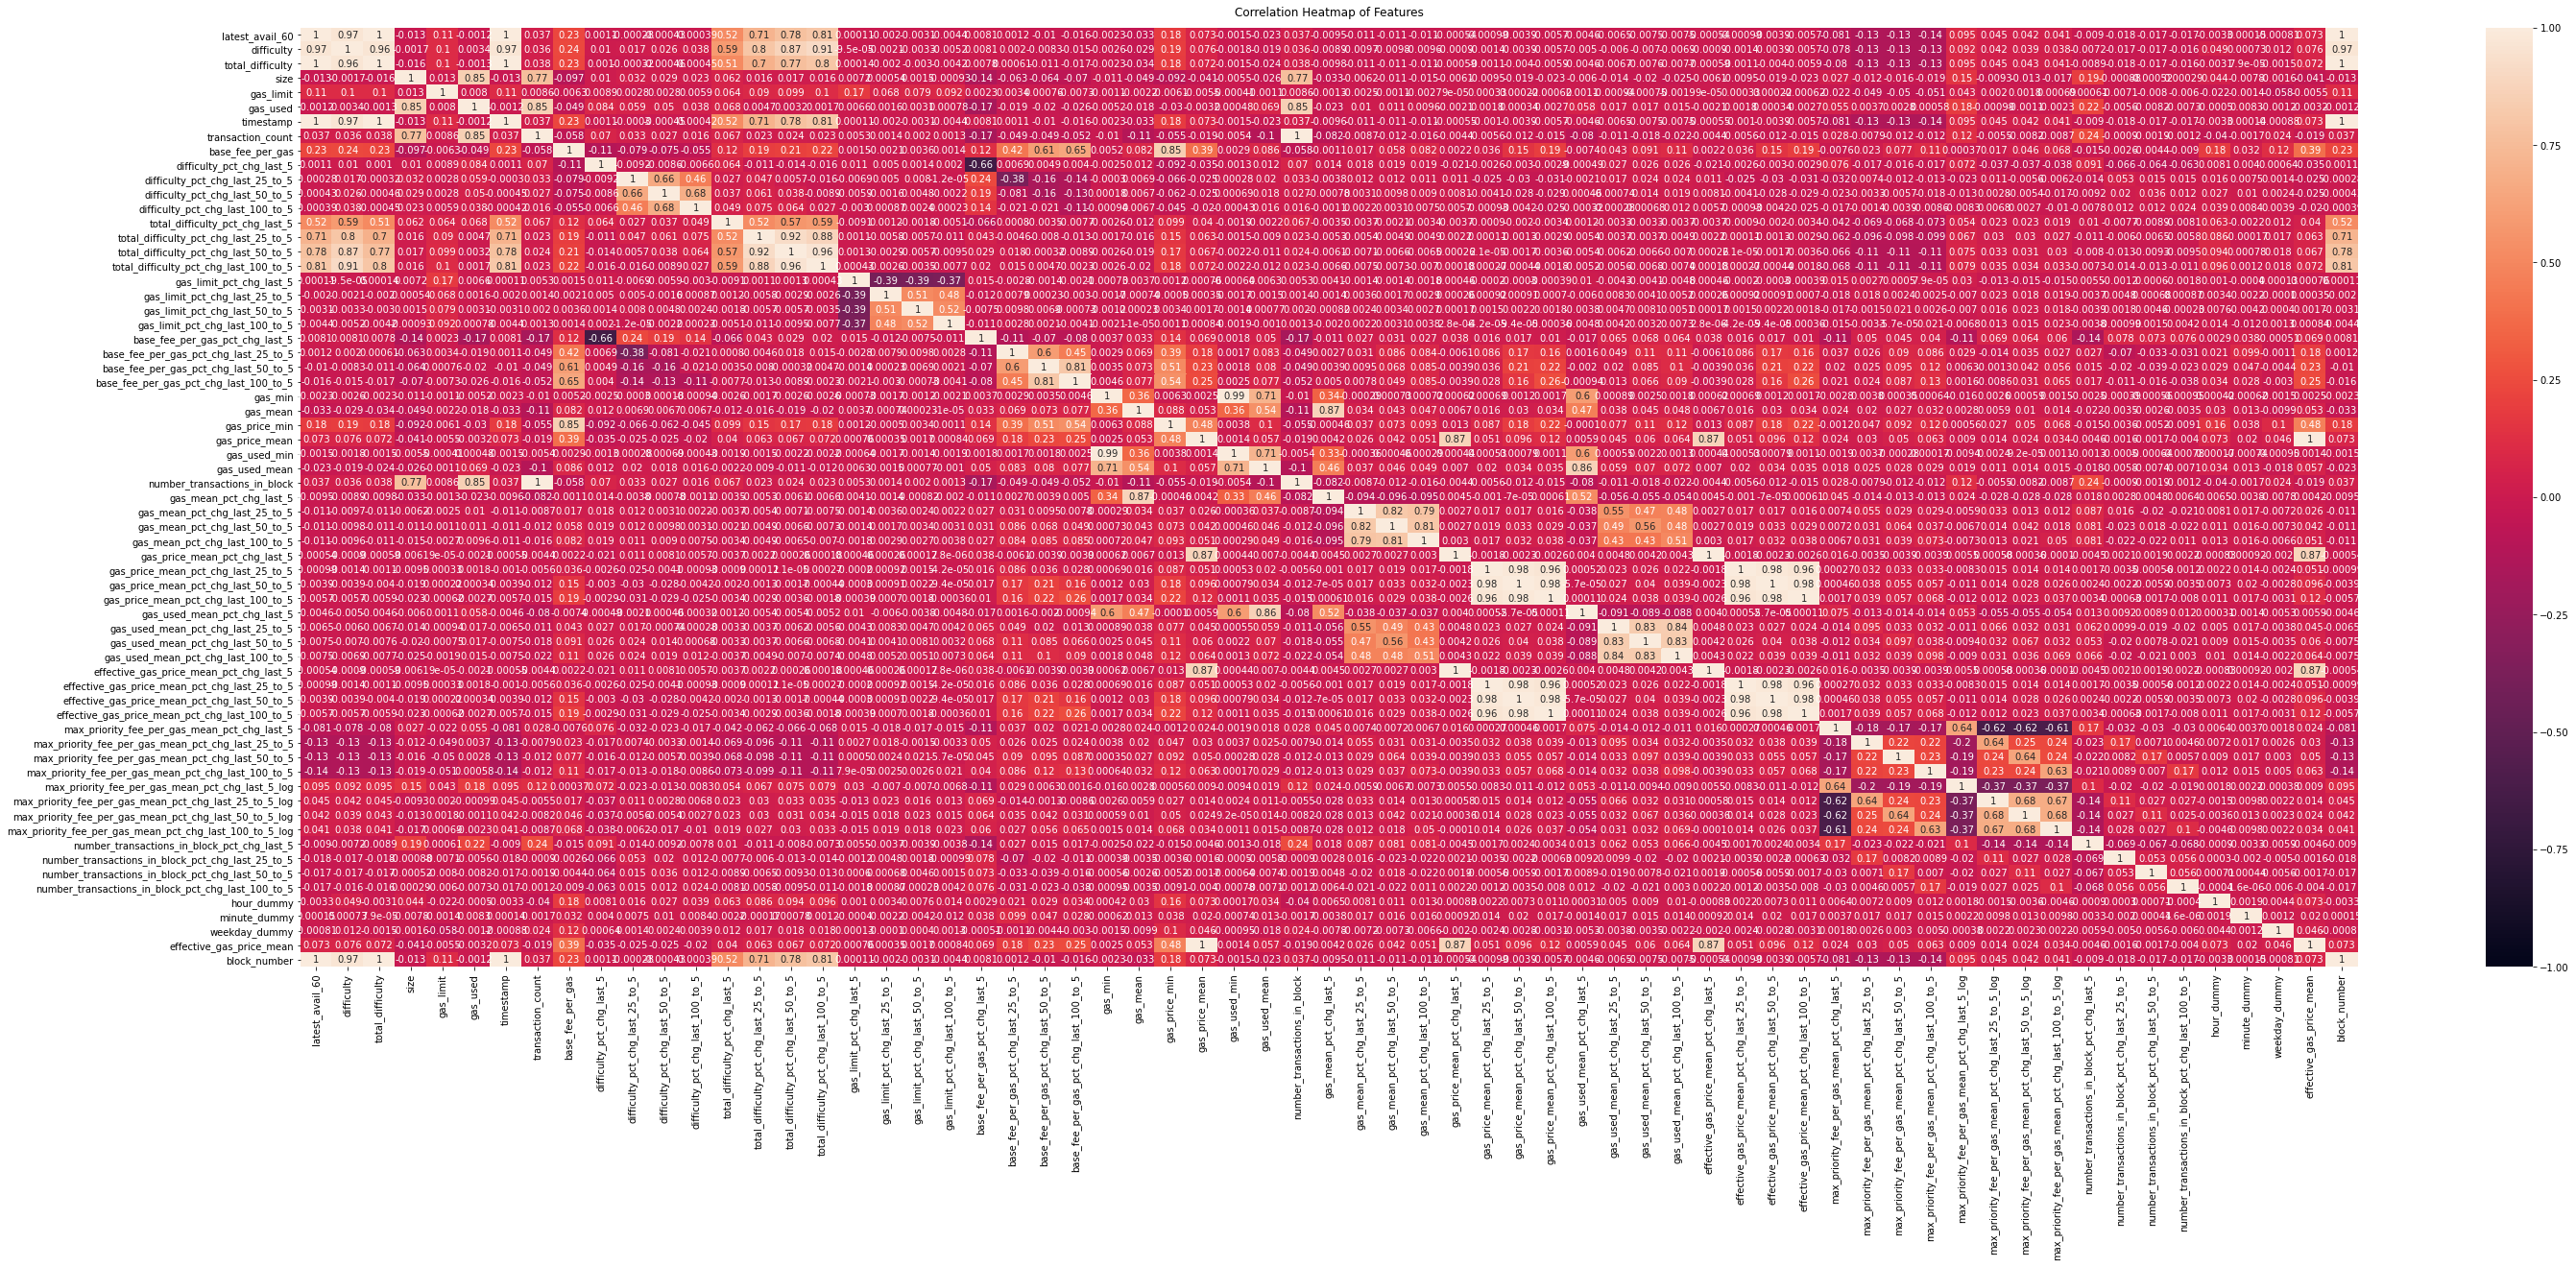

In [34]:
plt.figure(figsize=(48,18))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Features', fontdict={'fontsize':12}, pad=12);

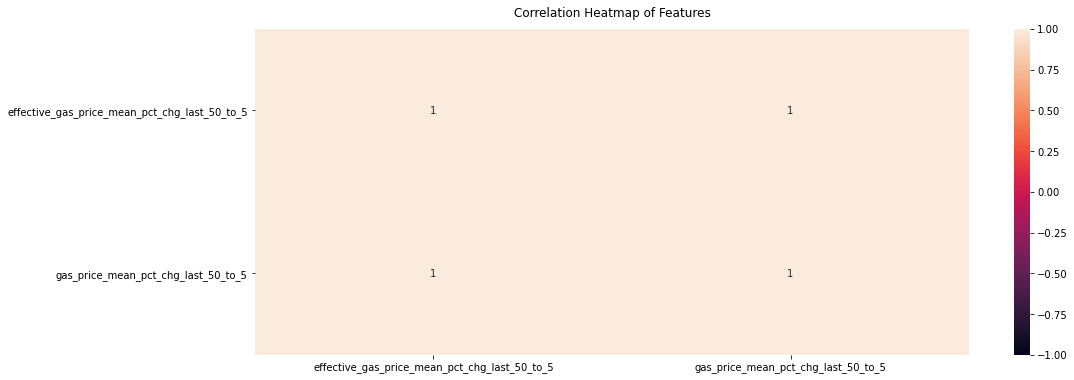

In [35]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(data[['effective_gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_50_to_5']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Features', fontdict={'fontsize':12}, pad=12);

#### Manually create feature list

In [36]:
lin_reg_features_list = [
    ['base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_25_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy'],
    ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy'],
    ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy'],
    ['base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_25_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_25_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_5_log',
             'minute_dummy', 'hour_dummy', 'weekday_dummy'],
    ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_50_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_5_log',
             'minute_dummy', 'hour_dummy', 'weekday_dummy'],
    ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5_log', 'max_priority_fee_per_gas_mean_pct_chg_last_5_log',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']
 ]

#### Run Regressions

In [37]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
linear_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
linear_regression_results_df['Coefficients'] = ''
linear_regression_results_df['Rsq_Train'] = ''
linear_regression_results_df['Rsq_Dev'] = ''
linear_regression_results_df['RMSE_Train'] = ''
linear_regression_results_df['RMSE_Dev'] = ''
linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",,,,,
3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,


In [38]:
lr_coeff_list = []
lr_rmse_train_list = []
lr_rmse_dev_list = []
lr_rsq_train_list = []
lr_rsq_dev_list = []

for l in lin_reg_features_list:
    lin_reg = LinearRegression(normalize=True, n_jobs=-1)

    lin_reg_features = l

    # fit train and test data. 
    lin_reg.fit(X_train[l], Y_train)

    # Predict train data. 
    y_train_pred = lin_reg.predict(X_train[l])

    # Get training metrics
    lr_mse_train = mean_squared_error(Y_train, y_train_pred)
    lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_lr = lin_reg.predict(X_dev[l])

    lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
    lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
    lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)
    
    # Store all of the results in lists
    lr_coeff_list.append(lin_reg.coef_)
    lr_rmse_train_list.append(lr_rmse_train)
    lr_rmse_dev_list.append(lr_rmse_dev)
    lr_rsq_train_list.append(lr_r2score_train)
    lr_rsq_dev_list.append(lr_r2score_dev)

# Store the lists of results into the results dataframe
linear_regression_results_df['Coefficients'] = lr_coeff_list
linear_regression_results_df['RMSE_Train'] = lr_rmse_train_list
linear_regression_results_df['RMSE_Dev'] = lr_rmse_dev_list
linear_regression_results_df['Rsq_Train'] = lr_rsq_train_list
linear_regression_results_df['Rsq_Dev'] = lr_rsq_dev_list

linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144073801143.88983, 82238916086.64957, 89720...",0.845726,0.262036,1.066710e+11,1.191900e+11
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[70557944812.70964, 76728253211.66951, -54071...",0.865366,0.292649,9.965025e+10,1.166916e+11
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[60907611405.06572, 84207886230.9525, -149469...",0.872186,0.326687,9.709334e+10,1.138494e+11
3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144935454260.87268, 81918733023.41081, 19180...",0.845183,0.260841,1.068585e+11,1.192864e+11
4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[71344421709.45357, 76806424963.13821, 664958...",0.864538,0.291612,9.995591e+10,1.167771e+11


In [39]:
linear_regression_results_df

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144073801143.88983, 82238916086.64957, 89720...",0.845726,0.262036,1.066710e+11,1.191900e+11
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[70557944812.70964, 76728253211.66951, -54071...",0.865366,0.292649,9.965025e+10,1.166916e+11
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[60907611405.06572, 84207886230.9525, -149469...",0.872186,0.326687,9.709334e+10,1.138494e+11
3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144935454260.87268, 81918733023.41081, 19180...",0.845183,0.260841,1.068585e+11,1.192864e+11
4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[71344421709.45357, 76806424963.13821, 664958...",0.864538,0.291612,9.995591e+10,1.167771e+11
5,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[61815704993.14524, 84582045857.56963, -17451...",0.871203,0.326353,9.746610e+10,1.138776e+11


#### Run Final Linear Regression Model

In [29]:
# Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)

lin_reg_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']


# fit train and test data. 
lin_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred = lin_reg.predict(X_train[lin_reg_features])

# Get training metrics
lr_mse_train = mean_squared_error(Y_train, y_train_pred)
lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Linear Regression model on train data is: %.4f'%lr_mse_train)
print ('The RMSE of the Linear Regression model on train data is: %.4f'%lr_rmse_train)
print ('The R^2 of the Linear Regression model on train data is: %.4f'%lr_r2score_train)

# Predict dev data. 
y_dev_pred_lr = lin_reg.predict(X_dev[lin_reg_features])

lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)

print ('The MSE of the Linear Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Linear Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Linear Regression model on dev data is: %.4f'%lr_r2score_dev)

lin_reg.coef_

The MSE of the Linear Regression model on train data is: 9427115780889391398912.0000
The RMSE of the Linear Regression model on train data is: 97093335409.2308
The R^2 of the Linear Regression model on train data is: 0.8722
The MSE of the Linear Regression model on dev data is: 12961687635241675522048.0000
The RMSE of the Linear Regression model on dev data is: 113849407707.0306
The R^2 of the Linear Regression model on dev data is: 0.3267


array([[ 6.09076114e+10,  8.42078862e+10, -1.49469035e+08,
         4.10879348e+07,  2.55034042e+09,  5.81103939e+10,
         1.86600162e+09,  1.43576037e+09,  1.08353636e+10,
         3.10215980e+10,  1.85371890e+10]])

In [34]:
import statsmodels.api as sm
mod = sm.OLS(Y_train,X_train[lin_reg_features])
mod2 = mod.fit()
print(mod2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     effective_gas_price_mean   R-squared (uncentered):                   0.880
Model:                                  OLS   Adj. R-squared (uncentered):              0.880
Method:                       Least Squares   F-statistic:                          2.521e+05
Date:                      Fri, 19 Nov 2021   Prob (F-statistic):                        0.00
Time:                              12:55:04   Log-Likelihood:                     -1.0116e+07
No. Observations:                    378271   AIC:                                  2.023e+07
Df Residuals:                        378260   BIC:                                  2.023e+07
Df Model:                                11                                                  
Covariance Type:                  nonrobust                                                  
                                                          co

In [42]:
linear_regression_results_df.to_csv(r'data/linear_regression_results_20211118_NoSize.csv')

In [35]:
linear_regression_results_df = pd.read_csv(r'data/linear_regression_results_20211118_NoSize.csv')

In [44]:
#len(y_dev_pred_lr)
#X_train
Y_dev['effective_gas_price_mean']

384308    6.559103e+11
384309    7.362075e+11
384310    7.663225e+11
384311    7.900478e+11
384312    7.714207e+11
              ...     
471935    9.101150e+10
471936    8.784644e+10
471937    9.296818e+10
471938    8.356565e+10
471939    8.613604e+10
Name: effective_gas_price_mean, Length: 87631, dtype: float64

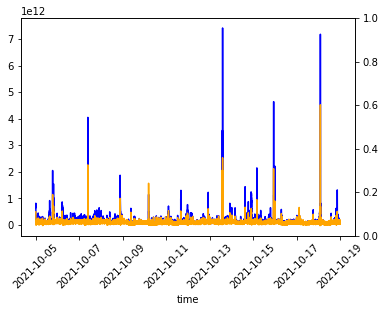

In [45]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = Y_dev - y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
ax1.plot(x, y2, color='orange')
#ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

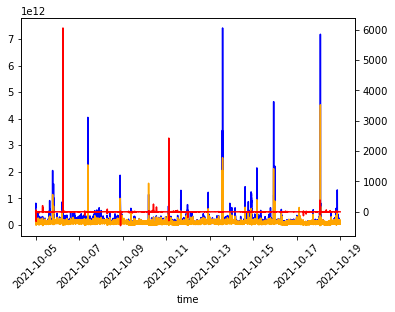

In [46]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = (Y_dev - y_dev_pred_lr) / y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
#ax2.plot(x, y2, color='orange')
ax1.plot(x, y2, color='orange')
ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [47]:
y3.sort_values(by='effective_gas_price_mean')

,effective_gas_price_mean
408833,-456.174283
384416,-312.859569
422807,-293.884375
428266,-186.787555
461393,-129.014288
...,...
386295,204.207242
418307,253.610412
466185,388.894296
422777,2429.481054


In [48]:
print(X_dev['datetime'].shape)
print(X_dev.index.shape)
print(np.array(Y_dev).flatten().shape)
print(y_dev_pred_lr.flatten())

(87631,)
(87631,)
(87631,)
[4.95107229e+11 4.88597552e+11 4.41117992e+11 ... 1.07770156e+11
 7.76207620e+10 7.78098137e+10]


In [49]:
lr_check_df = pd.DataFrame({'dt': X_dev['datetime'], 
                            'block_number': X_dev.index, 
                            'y': np.array(Y_dev).flatten(), 
                            'y_pred': y_dev_pred_lr.flatten()},
                          columns = ['dt', 'block_number', 'y', 'y_pred'])
lr_check_df

,dt,block_number,y,y_pred
384308,2021-10-05 00:00:19,384308,6.559103e+11,4.951072e+11
384309,2021-10-05 00:00:34,384309,7.362075e+11,4.885976e+11
384310,2021-10-05 00:00:58,384310,7.663225e+11,4.411180e+11
384311,2021-10-05 00:01:05,384311,7.900478e+11,4.581100e+11
384312,2021-10-05 00:01:13,384312,7.714207e+11,4.645663e+11
...,...,...,...,...
471935,2021-10-18 23:58:48,471935,9.101150e+10,8.903498e+10
471936,2021-10-18 23:58:55,471936,8.784644e+10,9.235648e+10
471937,2021-10-18 23:59:43,471937,9.296818e+10,1.077702e+11
471938,2021-10-18 23:59:50,471938,8.356565e+10,7.762076e+10


In [50]:
lr_check_df['diff'] = lr_check_df.y_pred - lr_check_df.y
lr_check_df['pct_diff'] = (lr_check_df.y_pred - lr_check_df.y)/lr_check_df.y
lr_check_df['abs_pct_diff'] = abs(lr_check_df['pct_diff'])
lr_check_df.sort_values(by='abs_pct_diff', ascending=False)

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff
386333,2021-10-05 07:40:12,386333,6.294473e+10,-2.215963e+10,-8.510436e+10,-1.352049,1.352049
386336,2021-10-05 07:40:16,386336,5.596463e+10,-1.813560e+10,-7.410023e+10,-1.324055,1.324055
417597,2021-10-10 07:13:55,417597,7.113141e+10,-1.470465e+10,-8.583606e+10,-1.206725,1.206725
438192,2021-10-13 14:14:27,438192,1.845677e+11,4.042614e+11,2.196937e+11,1.190315,1.190315
386298,2021-10-05 07:31:34,386298,7.618096e+10,-1.355527e+10,-8.973624e+10,-1.177935,1.177935
...,...,...,...,...,...,...,...
399500,2021-10-07 10:01:48,399500,1.175498e+11,1.175517e+11,1.953370e+06,0.000017,0.000017
435180,2021-10-13 02:20:33,435180,1.180860e+11,1.180877e+11,1.648947e+06,0.000014,0.000014
435679,2021-10-13 04:21:41,435679,7.243778e+10,7.243721e+10,-5.711381e+05,-0.000008,0.000008
463133,2021-10-17 14:05:52,463133,7.458095e+10,7.458151e+10,5.590056e+05,0.000007,0.000007


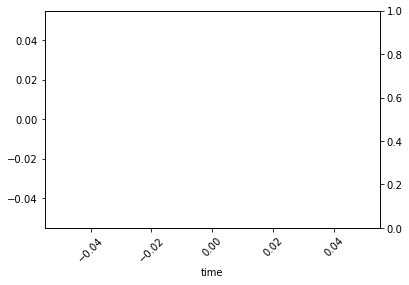

In [51]:
x = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['block_number']
y1 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y']
y2 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y_pred']
y3 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['pct_diff']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
ax1.plot(x, y2, color='orange')
#ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [52]:
lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff


In [53]:
X_dev.loc[477360:477400][lin_reg_features]

,base_fee_per_gas_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,number_transactions_in_block_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,minute_dummy,hour_dummy,weekday_dummy


In [54]:
data.loc[477393]['size']

44625

In [55]:
data.loc[477292]['size']

121063

In [56]:
X_dev.columns

Index(['lag_cutoff_60', 'latest_avail_60', 'datetime', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block

## Ridge Regression

In [57]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
ridge_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
ridge_regression_results_df['Coefficients'] = ''
ridge_regression_results_df['Rsq_Train'] = ''
ridge_regression_results_df['Rsq_Dev'] = ''
ridge_regression_results_df['RMSE_Train'] = ''
ridge_regression_results_df['RMSE_Dev'] = ''
ridge_regression_results_df

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",,,,,
3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,
5,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",,,,,


In [58]:
rr_coeff_list = []
rr_rmse_train_list = []
rr_rmse_dev_list = []
rr_rsq_train_list = []
rr_rsq_dev_list = []

for l in lin_reg_features_list:
    ridge_reg = Ridge(alpha=0.75, random_state=42)

    lin_reg_features = l

    # fit train and test data. 
    ridge_reg.fit(X_train[lin_reg_features], Y_train)

    # Predict train data. 
    y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

    # Get training metrics
    rr_mse_train = mean_squared_error(Y_train, y_train_pred)
    rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

    rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
    rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
    rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)
    
    # Store all of the results in lists
    rr_coeff_list.append(ridge_reg.coef_)
    rr_rmse_train_list.append(rr_rmse_train)
    rr_rmse_dev_list.append(rr_rmse_dev)
    rr_rsq_train_list.append(rr_r2score_train)
    rr_rsq_dev_list.append(rr_r2score_dev)

# Store the lists of results into the results dataframe
ridge_regression_results_df['Coefficients'] = rr_coeff_list
ridge_regression_results_df['RMSE_Train'] = rr_rmse_train_list
ridge_regression_results_df['RMSE_Dev'] = rr_rmse_dev_list
ridge_regression_results_df['Rsq_Train'] = rr_rsq_train_list
ridge_regression_results_df['Rsq_Dev'] = rr_rsq_dev_list

ridge_regression_results_df

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144071161384.57758, 82231778301.78647, 89720...",0.872186,0.262036,9.709334e+10,1.191900e+11
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[70557680719.95676, 76721959917.98148, -54066...",0.872186,0.292649,9.709334e+10,1.166917e+11
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[60907415591.652054, 84200983691.01736, -1494...",0.872186,0.326687,9.709334e+10,1.138494e+11
3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[144932808277.97293, 81911614128.36372, 19180...",0.872186,0.260841,9.709334e+10,1.192864e+11
4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[71344158165.82416, 76800117796.34868, 665016...",0.872186,0.291612,9.709334e+10,1.167771e+11
5,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[61815509808.71032, 84575102625.47818, -17444...",0.872186,0.326353,9.709334e+10,1.138777e+11


In [59]:
ridge_regression_results_df.to_csv(r'data/ridge_regression_results_20211118_NoSize.csv')

In [36]:
ridge_regression_results_df = pd.read_csv(r'data/ridge_regression_results_20211118_NoSize.csv')

In [61]:
ridge_regression_results_df

,Unnamed: 0,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",[[ 1.44071161e+11 8.22317783e+10 8.97209565e...,0.872186,0.262036,9.709334e+10,1.191900e+11
1,1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",[[ 7.05576807e+10 7.67219599e+10 -5.40663871e...,0.872186,0.292649,9.709334e+10,1.166917e+11
2,2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",[[ 6.09074156e+10 8.42009837e+10 -1.49462753e...,0.872186,0.326687,9.709334e+10,1.138494e+11
3,3,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",[[ 1.44932808e+11 8.19116141e+10 1.91807633e...,0.872186,0.260841,9.709334e+10,1.192864e+11
4,4,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",[[7.13441582e+10 7.68001178e+10 6.65016233e+07...,0.872186,0.291612,9.709334e+10,1.167771e+11
5,5,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",[[ 6.18155098e+10 8.45751026e+10 -1.74449478e...,0.872186,0.326353,9.709334e+10,1.138777e+11


#### Run the Final Ridge Regression

In [30]:
ridge_reg = Ridge(alpha=0.75, random_state=42)

lin_reg_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']


# fit train and test data. 
ridge_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

# Get training metrics
rr_mse_train = mean_squared_error(Y_train, y_train_pred)
rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

# Predict dev data. 
y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)

## Random Forest

#### Hyperparameter Tuning Random Search

In [63]:
n_estimators = [100, 200, 500, 1000]
max_depth = [2, 3, 5, 7, 10]
max_features = [3, 4, 5, 7, 8]
min_samples_leaf = [5, 10, 25, 50, 100, 200, 500]

rf_hyperparameters = []
for i in range(10):
    ne = random.randint(0, len(n_estimators)-1)
    md = random.randint(0, len(max_depth)-1)
    mf = random.randint(0, len(max_features)-1)
    msl = random.randint(0, len(min_samples_leaf)-1)
    rf_hyperparameters.append([n_estimators[ne],
                               max_depth[md],
                               max_features[mf],
                               min_samples_leaf[msl]])
rf_hyperparameters_df = pd.DataFrame(rf_hyperparameters,
                                  columns=['n_estimators',
                                           'max_depth',
                                           'max_features',
                                           'min_samples_leaf'])
print(rf_hyperparameters_df)


   n_estimators  max_depth  max_features  min_samples_leaf
0           200          7             3                50
1          1000          2             3                25
2           500          2             3               100
3           500          7             5               500
4           200          2             7                 5
5          1000          5             4                10
6           100         10             7                50
7           200          2             5                10
8           100         10             4                10
9           500          7             4                10


#### Run the random forest models

In [64]:
print(datetime.datetime.now())

2021-11-18 17:17:25.480457


In [65]:
# Set the random forest features
rf_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']

# Set the index of the list of hyperparameters
ne_idx = 0
md_idx = 1
mf_idx = 2
msl_idx = 3

# Initialize rmse lists of models
rf_RMSE_train_list = []
rf_RMSE_dev_list = []

counter = 1

# Loop through hyperparameters and run random forest models
for h in range(len(rf_hyperparameters)):
    
    # Instantiate the random forest
    rf = RandomForestRegressor(n_estimators = rf_hyperparameters[h][ne_idx], 
                               max_depth = rf_hyperparameters[h][ne_idx],
                               bootstrap = True,
                               max_features = rf_hyperparameters[h][mf_idx],
                               min_samples_leaf = rf_hyperparameters[h][msl_idx],
                               random_state = 42)

    # Train the model on the training data
    rf.fit(X_train[rf_features], Y_train)

    # Get the predictions on the training data set
    rf_train_predictions = rf.predict(X_train[rf_features])

    # Get the predictions on the dev data set
    rf_dev_predictions = rf.predict(X_dev[rf_features])


    rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
    rf_RMSE_train = np.sqrt(rf_MSE_train)
    rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
    rf_RMSE_dev = np.sqrt(rf_MSE_dev)
    rf_RMSE_train_list.append(rf_RMSE_train)
    rf_RMSE_dev_list.append(rf_RMSE_dev)
    
    # Purely to show progress
    print("Model #", counter)
    print(datetime.datetime.now())
    counter += 1

# Append the RMSE's to the dataframe
rf_hyperparameters_df['RMSE_Train'] = rf_RMSE_train_list
rf_hyperparameters_df['RMSE_Dev'] = rf_RMSE_dev_list

Model # 1
2021-11-18 17:21:23.997055
Model # 2
2021-11-18 17:42:47.548579
Model # 3
2021-11-18 17:51:59.188603
Model # 4
2021-11-18 18:04:04.350642
Model # 5
2021-11-18 18:14:48.575429
Model # 6
2021-11-18 18:45:17.774881
Model # 7
2021-11-18 18:49:40.329091
Model # 8
2021-11-18 18:57:08.691913
Model # 9
2021-11-18 19:00:10.410761
Model # 10
2021-11-18 19:15:26.302667


In [66]:
print(datetime.datetime.now())

2021-11-18 19:15:26.322685


In [67]:
rf_hyperparameters_df.sort_values(by='RMSE_Dev')

,n_estimators,max_depth,max_features,min_samples_leaf,RMSE_Train,RMSE_Dev
6,100,10,7,50,2.460880e+11,8.414023e+10
1,1000,2,3,25,2.425720e+11,8.593974e+10
5,1000,5,4,10,2.326363e+11,8.736943e+10
9,500,7,4,10,2.323931e+11,8.738222e+10
7,200,2,5,10,2.323530e+11,9.022265e+10
8,100,10,4,10,2.319566e+11,9.216656e+10
0,200,7,3,50,2.470226e+11,9.278800e+10
2,500,2,3,100,2.502382e+11,9.905715e+10
3,500,7,5,500,2.558050e+11,1.095198e+11
4,200,2,7,5,2.188755e+11,1.152181e+11


In [111]:
rf_hyperparameters_df.to_csv(r'data/rf_hyperparameters_20211118_NoSize.csv')

In [38]:
rf_hyperparameters_df = pd.read_csv(r'data/rf_hyperparameters_20211118_NoSize.csv')

#### Run the Final Random Forest Model After Picking Hyperparameters

In [31]:
rf_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']

In [32]:
# Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 100, 
                           max_depth = 10,
                           bootstrap = True,
                           max_features = 7,
                           min_samples_leaf = 50,
                           random_state = 42)

# Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

# Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

# Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
rf_RMSE_dev = np.sqrt(rf_MSE_dev)
print("rf_RMSE_train:", rf_RMSE_train)
print("rf_RMSE_dev:", rf_RMSE_dev)

rf_RMSE_train: 246611756443.7396
rf_RMSE_dev: 85945242269.28065


#### Feature Importance

                                             Features  Feature_Importance
4      effective_gas_price_mean_pct_chg_last_100_to_5            0.421498
5             effective_gas_price_mean_pct_chg_last_5            0.351722
0              base_fee_per_gas_pct_chg_last_100_to_5            0.139338
1                     base_fee_per_gas_pct_chg_last_5            0.053810
9                                          hour_dummy            0.011812
10                                      weekday_dummy            0.011744
6   max_priority_fee_per_gas_mean_pct_chg_last_100...            0.005856
7        max_priority_fee_per_gas_mean_pct_chg_last_5            0.002060
3         number_transactions_in_block_pct_chg_last_5            0.001403
8                                        minute_dummy            0.000580
2   number_transactions_in_block_pct_chg_last_100_...            0.000177


<AxesSubplot:title={'center':'Random Forest Feature Importance'}, ylabel='Features'>

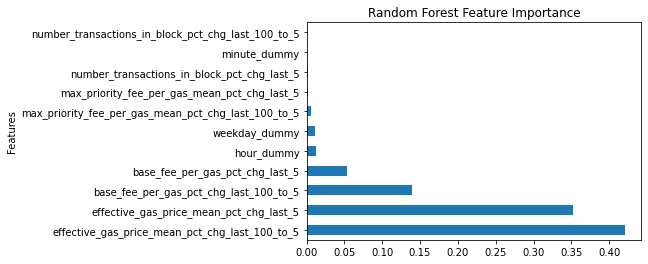

In [33]:
rf_feature_importances = rf.feature_importances_
rf_feature_importances_dict = {'Features': rf_features,
                               'Feature_Importance': rf_feature_importances}
rf_feature_importances_df = pd.DataFrame(rf_feature_importances_dict)
rf_feature_importances_df.sort_values(by=['Feature_Importance'], 
                                      ascending=False,
                                      inplace=True)
print(rf_feature_importances_df.head(30))

rf_feature_importances_df = rf_feature_importances_df.set_index('Features')
rf_feature_importances_df['Feature_Importance'].nlargest(15).plot(kind='barh',
                                                                  title='Random Forest Feature Importance')

In [98]:
data.columns

Index(['lag_cutoff_60', 'latest_avail_60', 'datetime', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block

## Gradient Boosting

#### Hyperparameter Tuning Random Search

In [71]:
# Gradient boosing hyperparameter random search
booster = ['dart', 'gbtree', 'gblinear']
max_depth = [2, 3, 5, 6, 7, 10]
learning_rate = [.001, .005, .01, .05]
subsample = [0.5, 0.6, 0.7]
rate_drop = [0.00, 0.10, 0.20, 0.40]
min_child_weight = [1, 5, 10, 25, 50, 100, 200, 500]
training_rounds = [200, 500, 1000]

xgb_hyperparameters = []
for i in range(10):
    
    # Randomly pick from specific hyperparameter lists
    b = random.randint(0, len(booster)-1)
    md = random.randint(0, len(max_depth)-1)
    l = random.randint(0, len(learning_rate)-1)
    s = random.randint(0, len(subsample)-1)
    r = random.randint(0, len(rate_drop)-1)
    mcw = random.randint(0, len(min_child_weight)-1)
    t = random.randint(0, len(training_rounds)-1)
    
    xgb_hyperparameters.append([booster[b],
                                max_depth[md],
                                learning_rate[l],
                                subsample[s],
                                rate_drop[r],
                                min_child_weight[mcw],
                                training_rounds[t]])

# Store randomly chosen hyperparameters into dataframe
xgb_hyperparameters_df = pd.DataFrame(xgb_hyperparameters,
                                      columns=['booster',
                                               'max_depth',
                                               'learning_rate',
                                               'subsample',
                                               'rate_drop',
                                               'min_child_weight',
                                               'training_rounds'])

In [72]:
xgb_hyperparameters_df

,booster,max_depth,learning_rate,subsample,rate_drop,min_child_weight,training_rounds
0,gbtree,10,0.001,0.5,0.2,100,200
1,gbtree,7,0.010,0.7,0.2,1,500
2,gblinear,7,0.010,0.7,0.4,50,200
3,gblinear,7,0.050,0.5,0.1,100,200
4,dart,5,0.005,0.7,0.4,500,500
5,dart,7,0.005,0.6,0.4,10,500
6,dart,10,0.005,0.6,0.0,100,500
7,gblinear,7,0.010,0.7,0.1,200,1000
8,gblinear,2,0.050,0.7,0.0,5,200
9,gblinear,7,0.050,0.6,0.1,1,1000


#### Run the gradient boosting models

In [73]:
# Set the gradient boosting features
xgb_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']


# Set the index of the list of hyperparameters
b_idx = 0
md_idx = 1
l_idx = 2
s_idx = 3
r_idx = 4
mcw_idx = 5
t_idx = 6

# Initialize rmse lists of models
xgb_RMSE_train_list = []
xgb_RMSE_dev_list = []

counter = 1

# Loop through hyperparameters and run random forest models
for h in range(len(xgb_hyperparameters)):
    
    #set up the training matrix
    dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
    xgb_dict = {
            'booster': xgb_hyperparameters[h][b_idx],
            'max_depth': xgb_hyperparameters[h][md_idx],
            'random_state': 42,
            'learning_rate': xgb_hyperparameters[h][l_idx],
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'sample_type': 'uniform',
            'subsample': xgb_hyperparameters[h][s_idx],
            'normalize_type': 'tree',
            'rate_drop': xgb_hyperparameters[h][r_idx],
            'min_child_weight': xgb_hyperparameters[h][mcw_idx]
        }
    #starting hyperparameter of training rounds
    training_rounds = xgb_hyperparameters[h][t_idx]

    #train the model
    bst = xgb.train(
        xgb_dict,
        dtrain,
        training_rounds,
        evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
        early_stopping_rounds=10) 


    training_rounds = bst.best_ntree_limit

    #get training predictions and MSE
    xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
    xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
    xgb_train_rmse = np.sqrt(xgb_train_mse)

    #get dev predictions and MSE
    xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
    xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
    xgb_dev_rmse = np.sqrt(xgb_dev_mse)

    xgb_RMSE_train_list.append(xgb_train_rmse)
    xgb_RMSE_dev_list.append(xgb_dev_rmse)
    
    # Purely to show progress
    print("Model #", counter)
    print(datetime.datetime.now())
    counter += 1


# Append the RMSE's to the dataframe
xgb_hyperparameters_df['RMSE_Train'] = xgb_RMSE_train_list
xgb_hyperparameters_df['RMSE_Dev'] = xgb_RMSE_dev_list

[0]	RMSE-rmse:184432623616.00000
[1]	RMSE-rmse:184328110080.00000
[2]	RMSE-rmse:184213454848.00000
[3]	RMSE-rmse:184099012608.00000
[4]	RMSE-rmse:183988060160.00000
[5]	RMSE-rmse:183873503232.00000
[6]	RMSE-rmse:183760977920.00000
[7]	RMSE-rmse:183648927744.00000
[8]	RMSE-rmse:183536828416.00000
[9]	RMSE-rmse:183433396224.00000
[10]	RMSE-rmse:183327653888.00000
[11]	RMSE-rmse:183224729600.00000
[12]	RMSE-rmse:183121543168.00000
[13]	RMSE-rmse:183010541568.00000
[14]	RMSE-rmse:182904324096.00000
[15]	RMSE-rmse:182792224768.00000
[16]	RMSE-rmse:182687891456.00000
[17]	RMSE-rmse:182575611904.00000
[18]	RMSE-rmse:182464004096.00000
[19]	RMSE-rmse:182361210880.00000
[20]	RMSE-rmse:182251995136.00000
[21]	RMSE-rmse:182141370368.00000
[22]	RMSE-rmse:182031450112.00000
[23]	RMSE-rmse:181927804928.00000
[24]	RMSE-rmse:181818490880.00000
[25]	RMSE-rmse:181708750848.00000
[26]	RMSE-rmse:181599125504.00000
[27]	RMSE-rmse:181496758272.00000
[28]	RMSE-rmse:181388738560.00000
[29]	RMSE-rmse:181280178

In [74]:
xgb_hyperparameters_df.sort_values(by='RMSE_Dev')

,booster,max_depth,learning_rate,subsample,rate_drop,min_child_weight,training_rounds,RMSE_Train,RMSE_Dev
1,gbtree,7,0.010,0.7,0.2,1,500,6.786744e+10,8.145139e+10
6,dart,10,0.005,0.6,0.0,100,500,2.489044e+11,9.375615e+10
9,gblinear,7,0.050,0.6,0.1,1,1000,9.709334e+10,1.138496e+11
3,gblinear,7,0.050,0.5,0.1,100,200,9.710696e+10,1.139155e+11
8,gblinear,2,0.050,0.7,0.0,5,200,9.710700e+10,1.139157e+11
7,gblinear,7,0.010,0.7,0.1,200,1000,9.710958e+10,1.139187e+11
2,gblinear,7,0.010,0.7,0.4,50,200,1.030018e+11,1.156443e+11
0,gbtree,10,0.001,0.5,0.2,100,200,2.758176e+11,1.649485e+11
5,dart,7,0.005,0.6,0.4,10,500,2.802182e+11,1.730902e+11
4,dart,5,0.005,0.7,0.4,500,500,2.822031e+11,1.763381e+11


In [75]:
xgb_hyperparameters_df.to_csv(r'data/xgb_hyperparameters_20211118_NoSize.csv')

In [ ]:
xgb_hyperparameters_df = pd.read_csv(r'data/xgb_hyperparameters_20211118_NoSize.csv')

#### Run the Final Gradient Boosting Model After Picking Hyperparameters

In [35]:
xgb_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5',
             'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 'max_priority_fee_per_gas_mean_pct_chg_last_5',
             'minute_dummy', 'hour_dummy', 'weekday_dummy']

In [36]:
#set up the training matrix
dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
xgb_dict = {
        'booster': 'gbtree',
        'max_depth': 7,
        'random_state': 42,
        'learning_rate': .01,
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'sample_type': 'uniform',
        'subsample': 0.7,
        'normalize_type': 'tree',
        'rate_drop': 0.2,
        'min_child_weight': 1
    }
#starting hyperparameter of training rounds
training_rounds = 500

#train the model
bst = xgb.train(
    xgb_dict,
    dtrain,
    training_rounds,
    evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
    early_stopping_rounds=10) 


training_rounds = bst.best_ntree_limit

#get training predictions and MSE
xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)

#print("XGB train mean squared error:", xgb_train_mse)
print("XGB train root mean squared error:", xgb_train_rmse)

#get dev predictions and MSE
xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
xgb_dev_rmse = np.sqrt(xgb_dev_mse)

#print("XGB dev mean squared error:", xgb_dev_mse)
print("XGB dev root mean squared error:", xgb_dev_rmse)

[0]	RMSE-rmse:183492689920.00000
[1]	RMSE-rmse:182407643136.00000
[2]	RMSE-rmse:181344239616.00000
[3]	RMSE-rmse:180323450880.00000
[4]	RMSE-rmse:179274121216.00000
[5]	RMSE-rmse:178253905920.00000
[6]	RMSE-rmse:177190322176.00000
[7]	RMSE-rmse:176193798144.00000
[8]	RMSE-rmse:175184183296.00000
[9]	RMSE-rmse:174194589696.00000
[10]	RMSE-rmse:173227491328.00000
[11]	RMSE-rmse:172330598400.00000
[12]	RMSE-rmse:171352965120.00000
[13]	RMSE-rmse:170452795392.00000
[14]	RMSE-rmse:169432760320.00000
[15]	RMSE-rmse:168524005376.00000
[16]	RMSE-rmse:167634649088.00000
[17]	RMSE-rmse:166701793280.00000
[18]	RMSE-rmse:165786157056.00000
[19]	RMSE-rmse:164904091648.00000
[20]	RMSE-rmse:164071653376.00000
[21]	RMSE-rmse:163203448832.00000
[22]	RMSE-rmse:162373189632.00000
[23]	RMSE-rmse:161449836544.00000
[24]	RMSE-rmse:160612237312.00000
[25]	RMSE-rmse:159824658432.00000
[26]	RMSE-rmse:158968578048.00000
[27]	RMSE-rmse:158130978816.00000
[28]	RMSE-rmse:157345103872.00000
[29]	RMSE-rmse:156572696

In [37]:
#feature importance
xgb_importance_weight = bst.get_score(importance_type='weight')
xgb_importance_gain = bst.get_score(importance_type='gain')
xgb_importance_weight_df = pd.DataFrame.from_dict(xgb_importance_weight,
                                                  orient='index',
                                                  columns=['weight'])
xgb_importance_gain_df = pd.DataFrame.from_dict(xgb_importance_gain,
                                                  orient='index',
                                                  columns=['gain'])
xgb_feature_importance_df = xgb_importance_weight_df.join(xgb_importance_gain_df)
xgb_feature_importance_df.sort_values(by=['weight'], ascending=False, inplace=True)                 
print(xgb_feature_importance_df.head(30))


                                                    weight          gain
effective_gas_price_mean_pct_chg_last_5             5718.0  1.916492e+26
base_fee_per_gas_pct_chg_last_100_to_5              5076.0  2.598597e+24
effective_gas_price_mean_pct_chg_last_100_to_5      4434.0  2.342642e+25
base_fee_per_gas_pct_chg_last_5                     3025.0  2.470809e+24
number_transactions_in_block_pct_chg_last_100_to_5  1487.0  2.168911e+24
number_transactions_in_block_pct_chg_last_5         1350.0  1.719284e+24
weekday_dummy                                       1267.0  4.065971e+24
max_priority_fee_per_gas_mean_pct_chg_last_5        1035.0  1.685002e+24
max_priority_fee_per_gas_mean_pct_chg_last_100_...  1030.0  1.284776e+24
hour_dummy                                           435.0  4.238116e+24
minute_dummy                                         259.0  1.854461e+24


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

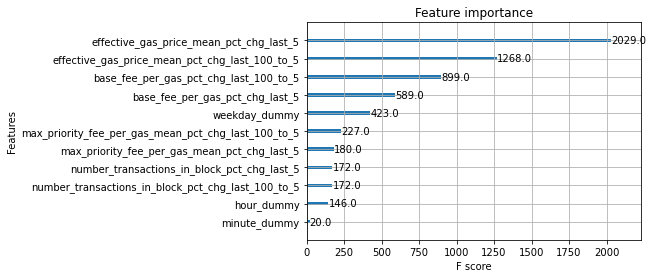

In [78]:
plot_importance(bst, max_num_features=30)

## Loading From File

In [38]:
lr_results_from_file = pd.read_csv(r'data/linear_regression_results_20211118_NoSize.csv')
lr_results_from_file['Model'] = 'Linear Regression'
lr_results_from_file = lr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in lr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rr_results_from_file = pd.read_csv(r'data/ridge_regression_results_20211118_NoSize.csv')
rr_results_from_file['Model'] = 'Ridge Regression'
rr_results_from_file = rr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rf_results_from_file = pd.read_csv(r'data/rf_hyperparameters_20211118_NoSize.csv')
rf_results_from_file['Model'] = 'Random Forest'
rf_results_from_file = rf_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rf_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

xgb_results_from_file = pd.read_csv(r'data/xgb_hyperparameters_20211118_NoSize.csv')
xgb_results_from_file['Model'] = 'Gradient Boosting'
xgb_results_from_file = xgb_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in xgb_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]


In [39]:
results_all_df = lr_results_from_file.append(rr_results_from_file).append(rf_results_from_file).append(xgb_results_from_file)

In [40]:
results_all_df = results_all_df.sort_values(by=['RMSE_Dev', 'RMSE_Train'])
results_all_df

,Model,RMSE_Dev,RMSE_Train,Unnamed: 0,Features,Coefficients,Rsq_Train,Rsq_Dev,n_estimators,max_depth,max_features,min_samples_leaf,booster,learning_rate,subsample,rate_drop,min_child_weight,training_rounds
1,Gradient Boosting,8.145139e+10,6.786744e+10,1,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,gbtree,0.010,0.7,0.2,1.0,500.0
6,Random Forest,8.414023e+10,2.460880e+11,6,NaN,NaN,NaN,NaN,100.0,10.0,7.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Random Forest,8.593974e+10,2.425720e+11,1,NaN,NaN,NaN,NaN,1000.0,2.0,3.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
5,Random Forest,8.736943e+10,2.326363e+11,5,NaN,NaN,NaN,NaN,1000.0,5.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Random Forest,8.738222e+10,2.323931e+11,9,NaN,NaN,NaN,NaN,500.0,7.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
7,Random Forest,9.022265e+10,2.323530e+11,7,NaN,NaN,NaN,NaN,200.0,2.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Random Forest,9.216656e+10,2.319566e+11,8,NaN,NaN,NaN,NaN,100.0,10.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
0,Random Forest,9.278800e+10,2.470226e+11,0,NaN,NaN,NaN,NaN,200.0,7.0,3.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
6,Gradient Boosting,9.375615e+10,2.489044e+11,6,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,dart,0.005,0.6,0.0,100.0,500.0
2,Random Forest,9.905715e+10,2.502382e+11,2,NaN,NaN,NaN,NaN,500.0,2.0,3.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN


## Ensemble

In [46]:
ensemble_train_preds = (y_train_pred.ravel() + y_train_pred_rr.ravel() + rf_train_predictions + xgb_train_pred) / 4
print("train_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_train_preds, Y_train))))

train_rmse = 101,133,643,806


In [47]:
ensemble_dev_preds = (y_dev_pred_lr.ravel() + y_dev_pred_rr.ravel() + rf_dev_predictions + xgb_dev_pred) / 4
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 95,256,452,249


In [48]:
ensemble_dev_preds = (y_dev_pred_lr.ravel() + y_dev_pred_rr.ravel() + 2*rf_dev_predictions + 2*xgb_dev_pred) / 6
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 90,176,022,073


In [49]:
ensemble_dev_preds = (rf_dev_predictions + xgb_dev_pred) / 2
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 82,331,015,823


In [50]:
ensemble_dev_preds = (rf_dev_predictions) / 1
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 85,945,242,269


In [51]:
ensemble_dev_preds = (xgb_dev_pred) / 1
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 81,451,388,839


In [52]:
ensemble_dev_preds = (rf_dev_predictions + 2*xgb_dev_pred) / 3
print("dev_rmse =", '{:,.0f}'.format(np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev))))

dev_rmse = 81,723,954,159


## Predictions Vs. Actuals

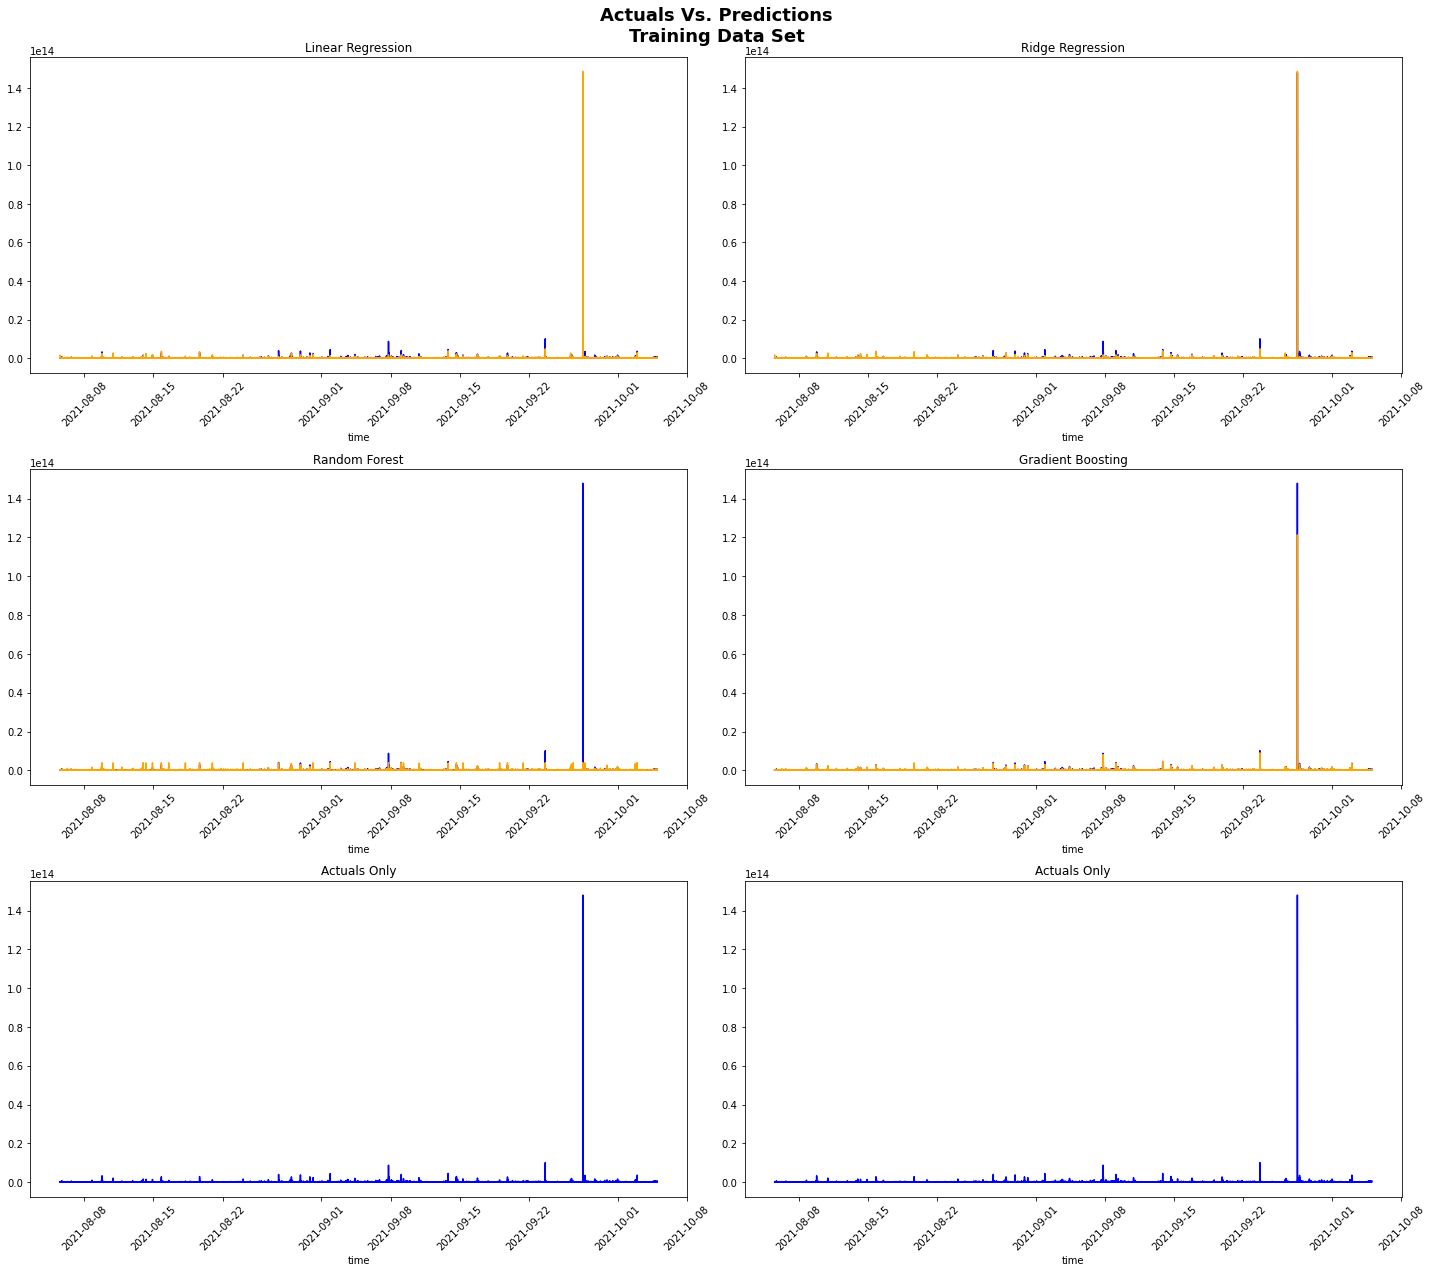

In [79]:

fig, ax = plt.subplots(3,2, figsize=(20, 18))

# Linear Regression
ax[0,0].plot(X_train['datetime'], Y_train, color='blue')
ax[0,0].plot(X_train['datetime'], y_train_pred, color='orange')
ax[0,0].set_xlabel('time')
ax[0,0].tick_params(axis='x', labelrotation=45)
ax[0,0].set_title('Linear Regression')

# Ridge Regression
ax[0,1].plot(X_train['datetime'], Y_train, color='blue')
ax[0,1].plot(X_train['datetime'], y_train_pred_rr, color='orange')
ax[0,1].set_xlabel('time')
ax[0,1].tick_params(axis='x', labelrotation=45)
ax[0,1].set_title('Ridge Regression')

# Random Forest
ax[1,0].plot(X_train['datetime'], Y_train, color='blue')
ax[1,0].plot(X_train['datetime'], rf_train_predictions, color='orange')
ax[1,0].set_xlabel('time')
ax[1,0].tick_params(axis='x', labelrotation=45)
ax[1,0].set_title('Random Forest')

# Gradient Boosting
ax[1,1].plot(X_train['datetime'], Y_train, color='blue')
ax[1,1].plot(X_train['datetime'], xgb_train_pred, color='orange')
ax[1,1].set_xlabel('time')
ax[1,1].tick_params(axis='x', labelrotation=45)
ax[1,1].set_title('Gradient Boosting')

# Actuals Only
ax[2,0].plot(X_train['datetime'], Y_train, color='blue')
ax[2,0].set_xlabel('time')
ax[2,0].tick_params(axis='x', labelrotation=45)
ax[2,0].set_title('Actuals Only')

# Actuals Only
ax[2,1].plot(X_train['datetime'], Y_train, color='blue')
ax[2,1].set_xlabel('time')
ax[2,1].tick_params(axis='x', labelrotation=45)
ax[2,1].set_title('Actuals Only')

fig.suptitle('Actuals Vs. Predictions\nTraining Data Set', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

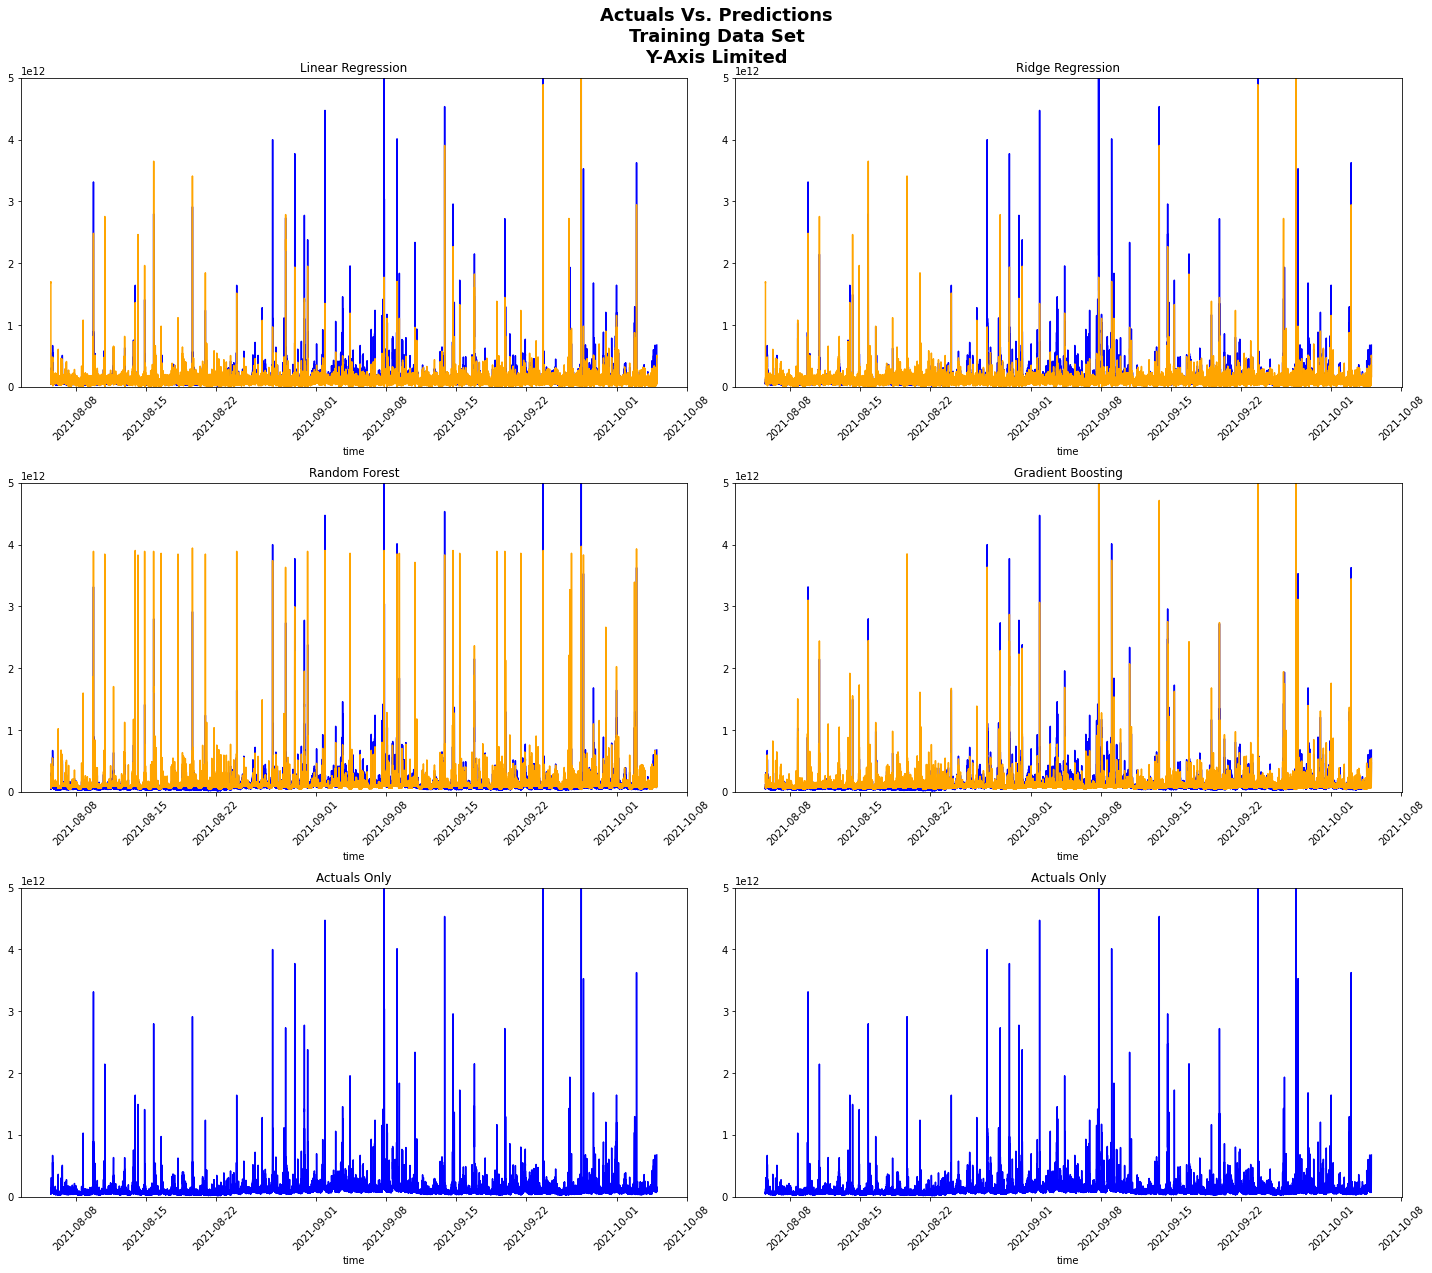

In [81]:

fig, ax = plt.subplots(3,2, figsize=(20, 18))

# Linear Regression
ax[0,0].plot(X_train['datetime'], Y_train, color='blue')
ax[0,0].plot(X_train['datetime'], y_train_pred, color='orange')
ax[0,0].set_xlabel('time')
ax[0,0].tick_params(axis='x', labelrotation=45)
ax[0,0].set_ylim(0, 5000000000000)
ax[0,0].set_title('Linear Regression')

# Ridge Regression
ax[0,1].plot(X_train['datetime'], Y_train, color='blue')
ax[0,1].plot(X_train['datetime'], y_train_pred_rr, color='orange')
ax[0,1].set_xlabel('time')
ax[0,1].tick_params(axis='x', labelrotation=45)
ax[0,1].set_ylim(0, 5000000000000)
ax[0,1].set_title('Ridge Regression')

# Random Forest
ax[1,0].plot(X_train['datetime'], Y_train, color='blue')
ax[1,0].plot(X_train['datetime'], rf_train_predictions, color='orange')
ax[1,0].set_xlabel('time')
ax[1,0].tick_params(axis='x', labelrotation=45)
ax[1,0].set_ylim(0, 5000000000000)
ax[1,0].set_title('Random Forest')

# Gradient Boosting
ax[1,1].plot(X_train['datetime'], Y_train, color='blue')
ax[1,1].plot(X_train['datetime'], xgb_train_pred, color='orange')
ax[1,1].set_xlabel('time')
ax[1,1].tick_params(axis='x', labelrotation=45)
ax[1,1].set_ylim(0, 5000000000000)
ax[1,1].set_title('Gradient Boosting')

# Actuals Only
ax[2,0].plot(X_train['datetime'], Y_train, color='blue')
ax[2,0].set_xlabel('time')
ax[2,0].tick_params(axis='x', labelrotation=45)
ax[2,0].set_ylim(0, 5000000000000)
ax[2,0].set_title('Actuals Only')

# Actuals Only
ax[2,1].plot(X_train['datetime'], Y_train, color='blue')
ax[2,1].set_xlabel('time')
ax[2,1].tick_params(axis='x', labelrotation=45)
ax[2,1].set_ylim(0, 5000000000000)
ax[2,1].set_title('Actuals Only')

fig.suptitle('Actuals Vs. Predictions\nTraining Data Set\nY-Axis Limited', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

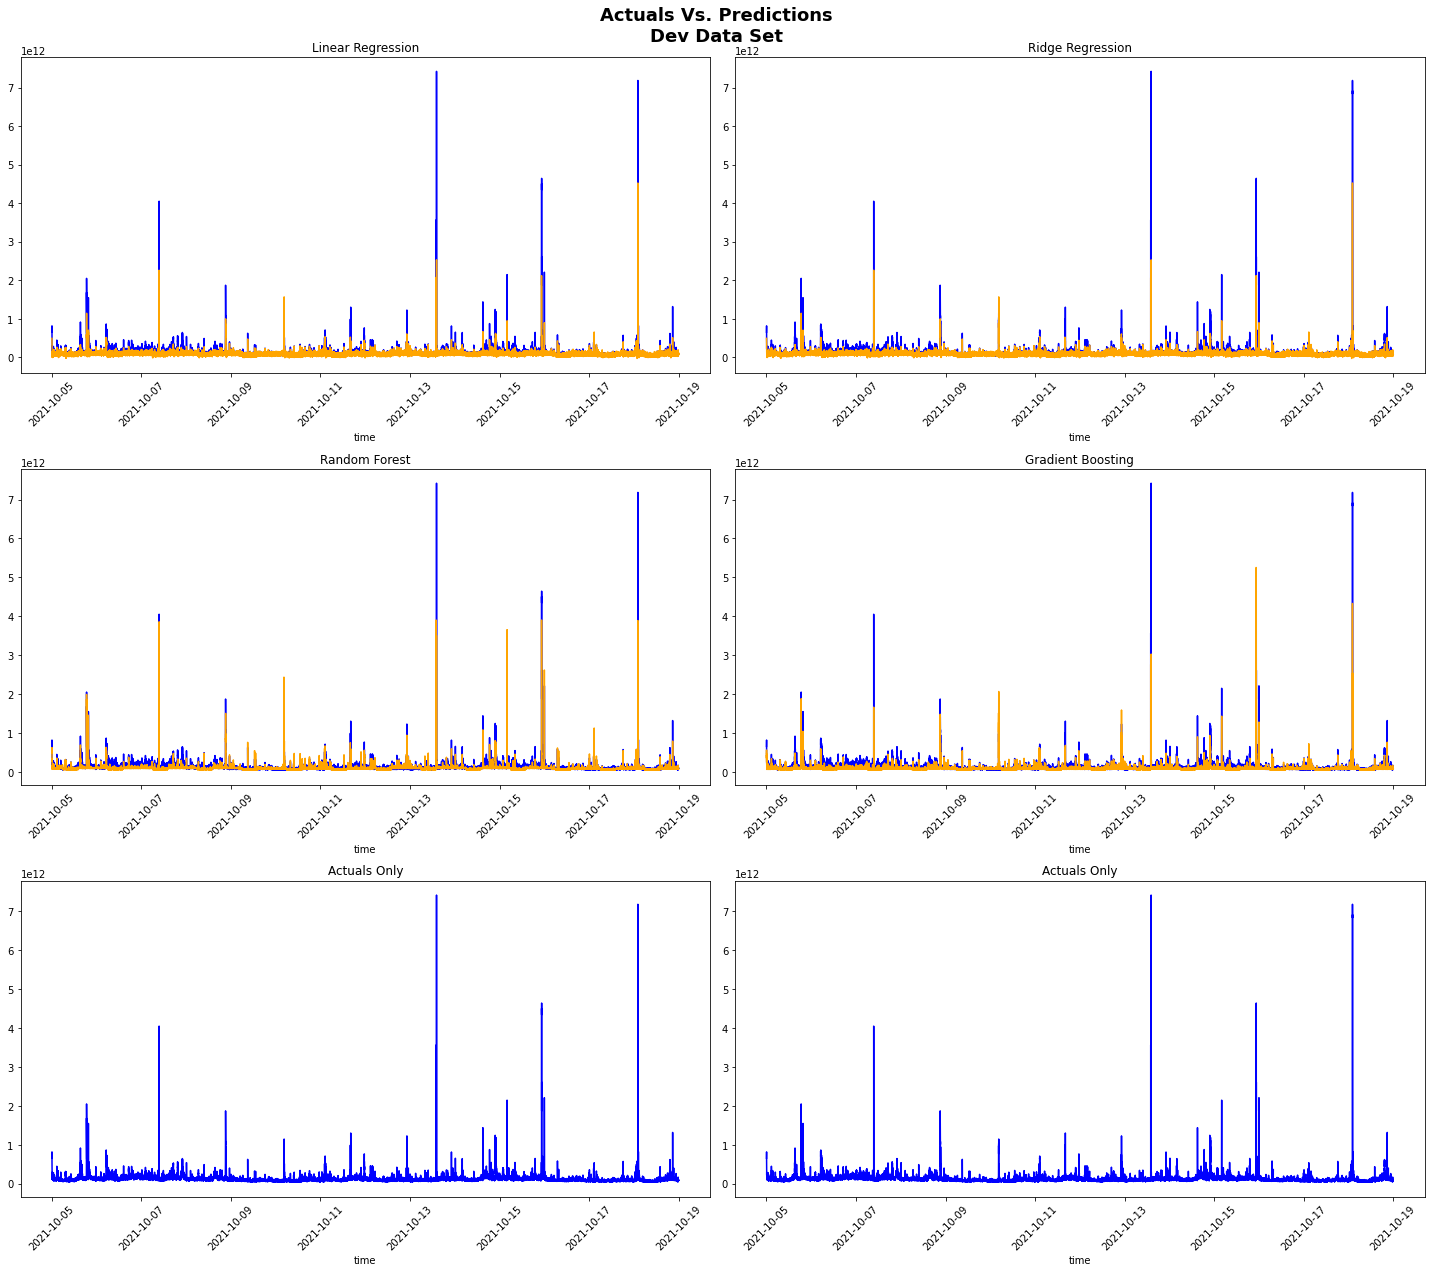

In [78]:
fig, ax = plt.subplots(3,2, figsize=(20, 18))

# Linear Regression
ax[0,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[0,0].plot(X_dev['datetime'], y_dev_pred_lr, color='orange')
ax[0,0].set_xlabel('time')
ax[0,0].tick_params(axis='x', labelrotation=45)
ax[0,0].set_title('Linear Regression')

# Ridge Regression
ax[0,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[0,1].plot(X_dev['datetime'], y_dev_pred_rr, color='orange')
ax[0,1].set_xlabel('time')
ax[0,1].tick_params(axis='x', labelrotation=45)
ax[0,1].set_title('Ridge Regression')

# Random Forest
ax[1,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[1,0].plot(X_dev['datetime'], rf_dev_predictions, color='orange')
ax[1,0].set_xlabel('time')
ax[1,0].tick_params(axis='x', labelrotation=45)
ax[1,0].set_title('Random Forest')

# Gradient Boosting
ax[1,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[1,1].plot(X_dev['datetime'], xgb_dev_pred, color='orange')
ax[1,1].set_xlabel('time')
ax[1,1].tick_params(axis='x', labelrotation=45)
ax[1,1].set_title('Gradient Boosting')

# Actuals Only
ax[2,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[2,0].set_xlabel('time')
ax[2,0].tick_params(axis='x', labelrotation=45)
ax[2,0].set_title('Actuals Only')

# Actuals Only
ax[2,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[2,1].set_xlabel('time')
ax[2,1].tick_params(axis='x', labelrotation=45)
ax[2,1].set_title('Actuals Only')

fig.suptitle('Actuals Vs. Predictions\nDev Data Set', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

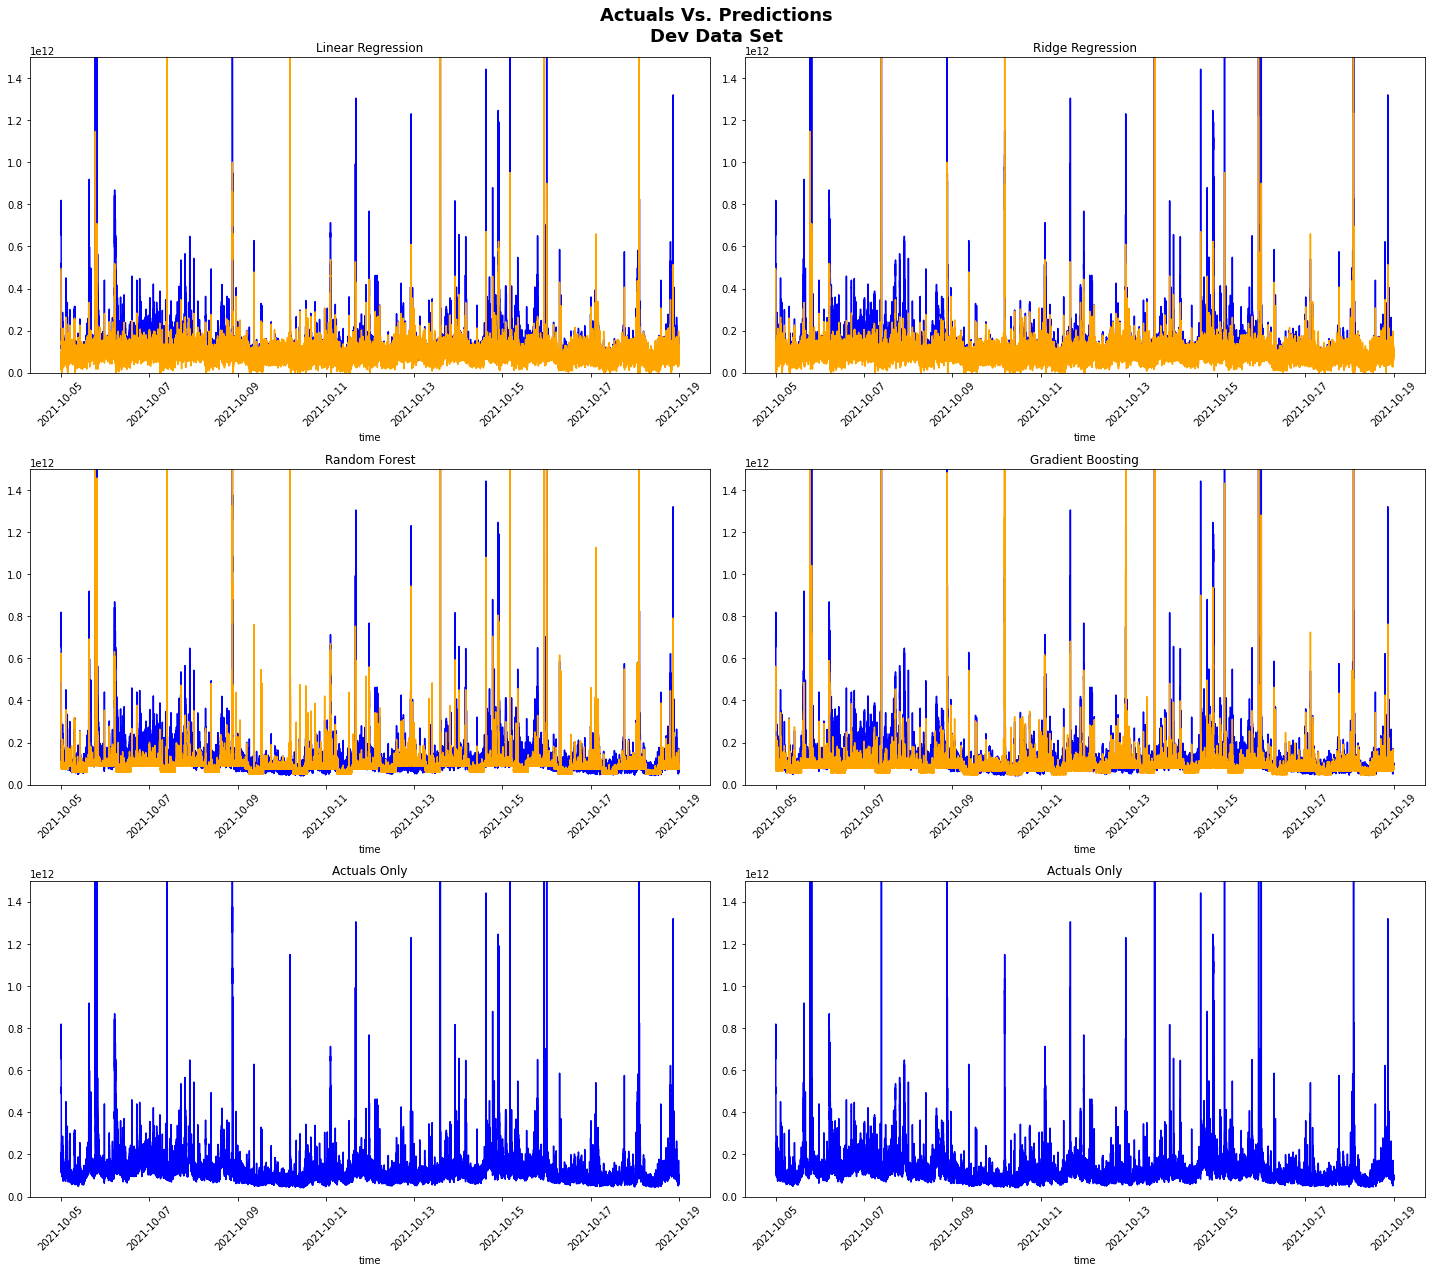

In [47]:
fig, ax = plt.subplots(3,2, figsize=(20, 18))

# Linear Regression
ax[0,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[0,0].plot(X_dev['datetime'], y_dev_pred_lr, color='orange')
ax[0,0].set_xlabel('time')
ax[0,0].tick_params(axis='x', labelrotation=45)
ax[0,0].set_ylim(0, 1500000000000)
ax[0,0].set_title('Linear Regression')

# Ridge Regression
ax[0,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[0,1].plot(X_dev['datetime'], y_dev_pred_rr, color='orange')
ax[0,1].set_xlabel('time')
ax[0,1].tick_params(axis='x', labelrotation=45)
ax[0,1].set_ylim(0, 1500000000000)
ax[0,1].set_title('Ridge Regression')

# Random Forest
ax[1,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[1,0].plot(X_dev['datetime'], rf_dev_predictions, color='orange')
ax[1,0].set_xlabel('time')
ax[1,0].tick_params(axis='x', labelrotation=45)
ax[1,0].set_ylim(0, 1500000000000)
ax[1,0].set_title('Random Forest')

# Gradient Boosting
ax[1,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[1,1].plot(X_dev['datetime'], xgb_dev_pred, color='orange')
ax[1,1].set_xlabel('time')
ax[1,1].tick_params(axis='x', labelrotation=45)
ax[1,1].set_ylim(0, 1500000000000)
ax[1,1].set_title('Gradient Boosting')

# Actuals Only
ax[2,0].plot(X_dev['datetime'], Y_dev, color='blue')
ax[2,0].set_xlabel('time')
ax[2,0].tick_params(axis='x', labelrotation=45)
ax[2,0].set_ylim(0, 1500000000000)
ax[2,0].set_title('Actuals Only')

# Actuals Only
ax[2,1].plot(X_dev['datetime'], Y_dev, color='blue')
ax[2,1].set_xlabel('time')
ax[2,1].tick_params(axis='x', labelrotation=45)
ax[2,1].set_ylim(0, 1500000000000)
ax[2,1].set_title('Actuals Only')

fig.suptitle('Actuals Vs. Predictions\nDev Data Set', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
a = 1
a

In [57]:
y_dev_pred_lr

array([[4.95107229e+11],
       [4.88597552e+11],
       [4.41117992e+11],
       ...,
       [1.07770156e+11],
       [7.76207620e+10],
       [7.78098137e+10]])